In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics
import logging
import os
import sys
from cgi import test
from glob import glob
from pydoc import describe
import numpy as np
import pandas as pd
from joblib import dump, load
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import (
    BayesianRidge,
    ElasticNet,
    LinearRegression,
    SGDRegressor,
)
from sklearn.model_selection import train_test_split
from sklearn.multioutput import RegressorChain
# from sklearnex import patch_sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply, MaxPooling1D
from tensorflow.keras.layers import InputLayer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Model


In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
df_pre = pd.read_csv('C:/Users/vp322/Documents/Nam4/NCKH/DATA/Risk_2 - smooth.csv', sep=",", dtype=str)
df_pre = df_pre[['PM2.5_s','wd_s','ws_s','Rainfall_s','lowleaf_s','temp_s','uvb_s']]
df_pre.head()

,PM2.5_s,wd_s,ws_s,Rainfall_s,lowleaf_s,temp_s,uvb_s
0,24.33,349.33,1.37,0.00,1.92,296.92,0.00
1,27.33,341.67,1.37,0.00,1.92,296.40,0.00
2,31.33,342.00,1.40,0.00,1.92,295.95,0.00
3,33.00,346.33,1.33,0.00,1.92,295.94,4580.61
4,36.67,245.00,1.20,0.00,1.92,296.41,29870.49


In [5]:
values = df_pre.values
# ensure all data is float
values = values.astype('float32')
temp = pd.DataFrame(values)
temp.head()

,0,1,2,3,4,5,6
0,24.330000,349.329987,1.37,0.0,1.92,296.920013,0.000000
1,27.330000,341.670013,1.37,0.0,1.92,296.399994,0.000000
2,31.330000,342.000000,1.40,0.0,1.92,295.950012,0.000000
3,33.000000,346.329987,1.33,0.0,1.92,295.940002,4580.609863
4,36.669998,245.000000,1.20,0.0,1.92,296.410004,29870.490234


In [6]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [7]:
#Single timestep no scale
# frame as supervised learning
n_hours = 18 # check timestep change  timestep to evaluate performance


n_features = 7  # fixed 7 values in data  (PM2.5_s	wd_s	ws_s	Rainfall_s	lowleaf_s	temp_s	uvb_s)
reframed = series_to_supervised(scaled, n_hours, 1)  # apply scaled not values
reframed.head()

,var1(t-18),var2(t-18),var3(t-18),var4(t-18),var5(t-18),var6(t-18),var7(t-18),var1(t-17),var2(t-17),var3(t-17),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
18,0.152534,0.971198,0.183261,0.0,0.466667,0.222088,0.000000,0.172148,0.949861,0.183261,...,0.466667,0.407566,0.0,0.150376,0.405738,0.307359,0.0,0.466667,0.370956,0.0
19,0.172148,0.949861,0.183261,0.0,0.466667,0.190359,0.000000,0.198300,0.950780,0.187590,...,0.466667,0.370956,0.0,0.152534,0.363955,0.259740,0.0,0.466667,0.341673,0.0
20,0.198300,0.950780,0.187590,0.0,0.466667,0.162905,0.000000,0.209219,0.962841,0.177489,...,0.466667,0.341673,0.0,0.176528,0.284123,0.216450,0.0,0.466667,0.311777,0.0
21,0.209219,0.962841,0.177489,0.0,0.466667,0.162294,0.010598,0.233213,0.680585,0.158730,...,0.466667,0.311777,0.0,0.226675,0.173621,0.183261,0.0,0.466667,0.281271,0.0
22,0.233213,0.680585,0.158730,0.0,0.466667,0.190971,0.069108,0.198300,0.399248,0.139971,...,0.466667,0.281271,0.0,0.268061,0.402033,0.177489,0.0,0.466667,0.248932,0.0


In [8]:
# split into train and test sets
values = reframed.values
n_train_hours = 32469  # het nam 2021
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]   # test dau nam 2022 den 2023

In [9]:
# split into input and outputs
n_obs = n_hours * n_features
print(n_obs)
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)


126
(32469, 126) 32469 (32469,)


In [10]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(32469, 18, 7) (32469,) (11123, 18, 7) (11123,)


In [11]:
print(train_X.shape[1])
print(train_X.shape[2])

18
7


In [12]:

# model 1
def LSTMandCNN(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=256, kernel_size=1, activation='relu')(inputs)
    bi1 = Bidirectional(LSTM(128, activation='relu', return_sequences=True))(x)
    max1d= tf.keras.layers.GlobalAveragePooling1D()(bi1)
    dropout = Dropout(0.2)(max1d)
    dense1=Dense(128)(dropout)
    dense2=Dense(64)(dense1)
    dense3=Dense(1)(dense2)
    model=Model([inputs],dense3)
    return model

model = LSTMandCNN(input_shape=(train_X.shape[1], train_X.shape[2]))
model.summary()
model.compile(optimizer = 'adam',loss = 'mse')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 18, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 18, 256)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 18, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 437,505 (1.67 MB)

 Trainable params: 437,505 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:

# model 2
def LSTMandCNN(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=128, kernel_size=1, activation='relu')(inputs)
    bi1 = Bidirectional(LSTM(64, activation='relu', return_sequences=True))(x)
    max1d= tf.keras.layers.GlobalAveragePooling1D()(bi1)
    #dropout = Dropout(0.2)(max1d)
    #dense1=Dense(128)(dropout)
    #dense2=Dense(64)(dense1)
    dense3=Dense(1)(max1d)
    model=Model([inputs],dense3)
    return model

model = LSTMandCNN(input_shape=(train_X.shape[1], train_X.shape[2]))
model.summary()
model.compile(optimizer = 'adam',loss = 'mse')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 18, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 18, 128)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 18, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,969 (390.50 KB)

 Trainable params: 99,969 (390.50 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:

# model 3
def LSTMandCNN(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)
    bi1 = Bidirectional(LSTM(64, activation='relu', return_sequences=True))(x)
    max1d= tf.keras.layers.GlobalAveragePooling1D()(bi1)
    #dropout = Dropout(0.2)(max1d)
    #dense1=Dense(128)(dropout)
    #dense2=Dense(64)(dense1)
    dense3=Dense(1)(max1d)
    model=Model([inputs],dense3)
    return model

model = LSTMandCNN(input_shape=(train_X.shape[1], train_X.shape[2]))
model.summary()
model.compile(optimizer = 'adam',loss = 'mse')


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 18, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 18, 64)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 18, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:

# model 5
input_shape=(train_X.shape[1], train_X.shape[2])
model = Sequential([
    Conv1D(filters=5, kernel_size=1, activation='relu', input_shape=input_shape),
    #Conv1D(filters=8, kernel_size=1, activation='relu'),
    Bidirectional(LSTM(50, return_sequences=True)),
    MaxPooling1D(pool_size=2),
    #Dropout(0.5),
    #Bidirectional(LSTM(32)),
    #Dense(16, activation='relu'),
    Dense(1)
])




def LSTMandCNN(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=7, kernel_size=1, activation='relu')(inputs)
    bi1 = Bidirectional(LSTM(50, activation='relu', return_sequences=True))(x)
    max1d= tf.keras.layers.GlobalAveragePooling1D()(bi1)
    dropout = Dropout(0.5)(max1d)
    dense1=Dense(8)(dropout)
    #dense2=Dense(8)(dense1)
    dense3=Dense(1)(dense1)
    model=Model([inputs],dense3)
    return model

model = LSTMandCNN(input_shape=(train_X.shape[1], train_X.shape[2]))
model.summary()
model.compile(optimizer = 'adam',loss = 'mse')



c:\Users\vp322\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 18, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 18, 7)          │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 18, 100)        │        23,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,073 (94.04 KB)

 Trainable params: 24,073 (94.04 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply
from keras.models import Model
# from attention_utils import get_activations
from keras.layers import *
from keras.layers import LSTM
from keras.models import *
import numpy as np
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(1234)
from keras import backend as K
from keras.layers import InputLayer
from keras.optimizers import Adam
from keras import layers
from keras.models import Model
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context


In [18]:

# model 2
def LSTMandCNN(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=7, kernel_size=1, activation='relu')(inputs)
    bi1 = Bidirectional(LSTM(128, activation='relu', return_sequences=True))(x)
    max1d= tf.keras.layers.GlobalAveragePooling1D()(bi1)
    #dropout = Dropout(0.2)(max1d)
    #dense1=Dense(128)(dropout)
    #dense2=Dense(64)(dense1)
    dense3=Dense(1)(max1d)
    model=Model([inputs],dense3)
    model.compile(loss='mse', optimizer='adam')
    return model

model = LSTMandCNN(input_shape=(train_X.shape[1], train_X.shape[2]))
model.summary()
model.compile(optimizer = 'adam',loss = 'mse')


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 18, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 18, 7)          │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 18, 256)        │       139,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,577 (545.22 KB)

 Trainable params: 139,577 (545.22 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply

def create_Bi_LSTM(input_shape):
    inputs = Input(shape=input_shape)
    #x = Conv1D(filters=256, kernel_size=1, activation='relu')(inputs)
    bi1 = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    bi2 = Bidirectional(LSTM(64,  return_sequences=True))(bi1)
    #max1d= tf.keras.layers.GlobalAveragePooling1D()(bi1)
    dropout = Dropout(0.5)(bi2)
    # gru = tf.keras.layers.GRU(128,activation='relu', return_sequences=False)(dropout)
    attention_layer = attention()(dropout)
    dense1=Dense(128)(attention_layer)
    dense2=Dense(64)(dense1)
    dense3=Dense(1)(dense2)
    model=Model([inputs],dense3)
    model.compile(loss='mse', optimizer='adam')
    return model

model = create_Bi_LSTM(input_shape=(train_X.shape[1], train_X.shape[2]))
model.summary()
model.compile(optimizer = 'adam',loss = 'mse')

'''
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(1))
model.summary()
model.compile(optimizer = 'adam',loss = 'mse')
'''

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
'''
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work.
    return x + res
'''

'\ndef transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):\n\n    # Normalization and Attention\n    # "EMBEDDING LAYER"\n    x = layers.LayerNormalization(epsilon=1e-6)(inputs)\n\n    # "ATTENTION LAYER"\n    x = layers.MultiHeadAttention(\n        key_dim=head_size, num_heads=num_heads, dropout=dropout\n    )(x, x)\n    x = layers.Dropout(dropout)(x)\n    res = x + inputs\n\n    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work.\n    return x + res\n'

In [ ]:
'''
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)
'''

'\ndef build_model(\n    input_shape,\n    head_size,\n    num_heads,\n    ff_dim,\n    num_transformer_blocks,\n    mlp_units,\n    dropout=0,\n    mlp_dropout=0,\n):\n    inputs = keras.Input(shape=input_shape)\n    x = inputs\n\n    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks\n        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)\n\n    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)\n    for dim in mlp_units:\n        x = layers.Dense(dim, activation="elu")(x)\n        x = layers.Dropout(mlp_dropout)(x)\n    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through\n    return keras.Model(inputs, outputs)\n'

In [ ]:
'''
input_shape=(train_X.shape[1], train_X.shape[2])
model = build_model(
    input_shape,
    head_size=46, # Embedding size for attention
    num_heads=60, # Number of attention heads
    ff_dim=55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks = 1,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
model.summary()
'''

'\ninput_shape=(train_X.shape[1], train_X.shape[2])\nmodel = build_model(\n    input_shape,\n    head_size=46, # Embedding size for attention\n    num_heads=60, # Number of attention heads\n    ff_dim=55, # Hidden layer size in feed forward network inside transformer\n    num_transformer_blocks = 1,\n    mlp_units=[256],\n    mlp_dropout=0.4,\n    dropout=0.14,\n)\n\nmodel.compile(\n    loss="mean_squared_error",\n    optimizer=keras.optimizers.Adam(learning_rate=1e-4),\n    metrics=["mean_squared_error"],\n)\nmodel.summary()\n'

Epoch 1/67
508/508 - 33s - loss: 0.0060 - val_loss: 0.0038 - 33s/epoch - 65ms/step
Epoch 2/67
508/508 - 27s - loss: 0.0039 - val_loss: 0.0034 - 27s/epoch - 52ms/step
Epoch 3/67
508/508 - 26s - loss: 0.0037 - val_loss: 0.0034 - 26s/epoch - 50ms/step
Epoch 4/67
508/508 - 25s - loss: 0.0037 - val_loss: 0.0031 - 25s/epoch - 49ms/step
Epoch 5/67
508/508 - 24s - loss: 0.0035 - val_loss: 0.0036 - 24s/epoch - 48ms/step
Epoch 6/67
508/508 - 24s - loss: 0.0032 - val_loss: 0.0036 - 24s/epoch - 46ms/step
Epoch 7/67
508/508 - 26s - loss: 0.0029 - val_loss: 0.0024 - 26s/epoch - 52ms/step
Epoch 8/67
508/508 - 24s - loss: 0.0024 - val_loss: 0.0018 - 24s/epoch - 48ms/step
Epoch 9/67
508/508 - 25s - loss: 0.0021 - val_loss: 0.0017 - 25s/epoch - 49ms/step
Epoch 10/67
508/508 - 30s - loss: 0.0019 - val_loss: 0.0018 - 30s/epoch - 59ms/step
Epoch 11/67
508/508 - 27s - loss: 0.0018 - val_loss: 0.0017 - 27s/epoch - 53ms/step
Epoch 12/67
508/508 - 26s - loss: 0.0017 - val_loss: 0.0017 - 26s/epoch - 51ms/step
E

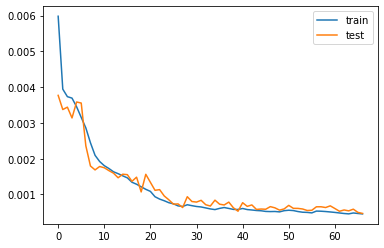

In [ ]:

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=30, verbose=1,
                               mode='min',
                               restore_best_weights=True)
#callbacks=[early_stopping]

# fit and train network
history = model.fit(train_X, train_y, epochs=67, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]


348/348 [==============================] - 4s 8ms/step


In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.4f' % rmse)

#calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.4f' % mae)

# r-squared score of the model
r2 = r2_score(inv_y, inv_yhat)
print('Test R2: %.4f'% r2)

Test RMSE: 3.3157
Test MAE: 2.4587
Test R2: 0.9289


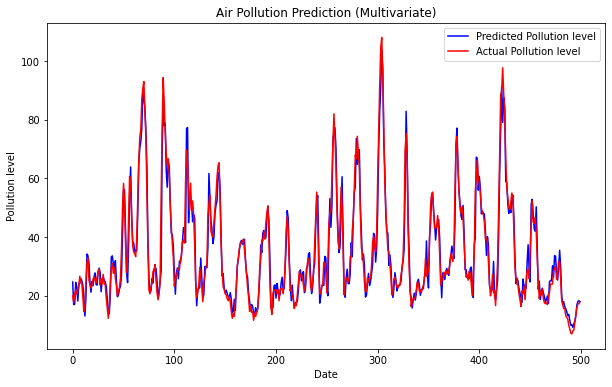

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(inv_yhat[:500], color= 'blue',label = 'Predicted Pollution level')
plt.plot(inv_y[:500] , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()
plt.savefig('graph.png')

In [ ]:
#write files
output = DataFrame([inv_y,inv_yhat]).T
#output.columns = ['actual','predicted']
#output.to_csv("LSTM"+"_"+"PM25_prediction_"+"timestep_"+str(n_hours)+".csv")
output

,0,1
0,20.000000,24.720951
1,17.666666,16.976276
2,20.666665,17.170451
3,22.000001,24.573482
4,20.666665,23.188101
...,...,...
11118,12.666667,13.125923
11119,12.999999,14.302214
11120,13.666667,13.977406
11121,15.000000,15.143125


In [ ]:
'''
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
'''
'''
model_CNNLSTM = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), input_shape=(win_length, num_features)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.7)),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(targets.shape[1])
])


'''
'''
Test RMSE: 3.5200
Test MAE: 2.7810
Test R2: 0.9199
'''

'\nTest RMSE: 3.5200\nTest MAE: 2.7810\nTest R2: 0.9199\n'